## License 

Copyright 2017 Patrick Hall and the H2O.ai team

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Increase Transparency and Accountability in Your Machine Learning Project with Python and H2O
#### Explain your complex models with decision tree surrogates, GBM feature importance, and reason codes

Decision trees and decision tree ensembles are some of the most popular machine learning models used in commercial practice. They can train and make predictions on data containing character values and missing values - both common in large commercial data stores. Single decision trees are easily represented as directed graphs, which can drastically increase their interpretability and transparency. Decision tree ensembles (i.e., random forests and gradient boosting machines (GBMs)), can be used to increase the accuracy and stability of single decision tree models, but are far less intepretable than single trees. These characteristics of decision trees will be leveraged here to increase transparency and accountability in complex, nonlinear, machine learning models.

This notebook starts by training a GBM on the UCI credit card default data using the popular open source library, h2o. A single decision tree *surrogate* model will then be trained on the original UCI credit card default data and the predictions from the h2o GBM, to create an approximate flow chart for the GBM's global decision-making processes. A technique known as leave-one-covariate-out (LOCO) will then be used to generate local explanations for any row-wise prediction made by the GBM model. Finally, local explanations are ensembled together from multiple similar models to increase explanation stability. 

#### Python imports
In general, NumPy and Pandas will be used for data manipulation purposes and h2o will be used for modeling tasks. 

In [1]:
# imports

# h2o Python API with specific classes
import h2o                                        
from h2o.estimators.gbm import H2OGradientBoostingEstimator       # for GBM

import numpy as np   # array, vector, matrix calculations
import pandas as pd  # DataFrame handling

%matplotlib inline

#### Start h2o
H2o is both a library and a server. The machine learning algorithms in the library take advantage of the multithreaded and distributed architecture provided by the server to train machine learning algorithms extremely efficiently. The API for the library was imported above in cell 1, but the server still needs to be started.

In [2]:
h2o.init(max_mem_size='2G')       # start h2o
h2o.remove_all()                  # remove any existing data structures from h2o memory

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_191"; Java(TM) SE Runtime Environment (build 1.8.0_191-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpgxuot6tk
  JVM stdout: /tmp/tmpgxuot6tk/h2o_patrickh_started_from_python.out
  JVM stderr: /tmp/tmpgxuot6tk/h2o_patrickh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,00 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.4
H2O cluster version age:,4 months and 24 days !!!
H2O cluster name:,H2O_from_python_patrickh_083uhb
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


## 1. Download, explore, and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005.

Because h2o accepts both numeric and character inputs, some variables will be recoded into more transparent character values.

#### Import data and clean
The credit card default data is available as an `.xls` file. Pandas reads `.xls` files automatically, so it's used to load the credit card default data and give the prediction target a shorter name: `DEFAULT_NEXT_MONTH`.

In [3]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1)

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles
The shorthand name `y` is assigned to the prediction target. `X` is assigned to all other input variables in the credit card default data except the row indentifier, `ID`.

In [4]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Helper function for recoding values in the UCI credict card default data
This simple function maps longer, more understandable character string values from the UCI credit card default data dictionary to the original integer values of the input variables found in the dataset. These character values can be used directly in h2o decision tree models, and the function returns the original Pandas DataFrame as an h2o object, an H2OFrame. H2o models cannot run on Pandas DataFrames. They require H2OFrames.

In [5]:
def recode_cc_data(frame):
    
    """ Recodes numeric categorical variables into categorical character variables
    with more transparent values. 
    
    Args:
        frame: Pandas DataFrame version of UCI credit card default data.
        
    Returns: 
        H2OFrame with recoded values.
        
    """
    
    # define recoded values
    sex_dict = {1:'male', 2:'female'}
    education_dict = {0:'other', 1:'graduate school', 2:'university', 3:'high school', 
                      4:'other', 5:'other', 6:'other'}
    marriage_dict = {0:'other', 1:'married', 2:'single', 3:'divorced'}
    pay_dict = {-2:'no consumption', -1:'pay duly', 0:'use of revolving credit', 1:'1 month delay', 
                2:'2 month delay', 3:'3 month delay', 4:'4 month delay', 5:'5 month delay', 6:'6 month delay', 
                7:'7 month delay', 8:'8 month delay', 9:'9+ month delay'}
    
    # recode values using Pandas apply() and anonymous function
    frame['SEX'] = frame['SEX'].apply(lambda i: sex_dict[i])
    frame['EDUCATION'] = frame['EDUCATION'].apply(lambda i: education_dict[i])    
    frame['MARRIAGE'] = frame['MARRIAGE'].apply(lambda i: marriage_dict[i]) 
    for name in frame.columns:
        if name in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
            frame[name] = frame[name].apply(lambda i: pay_dict[i])            
                
    return h2o.H2OFrame(frame)

data = recode_cc_data(data)

/home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Ensure target is handled as a categorical variable

In h2o, a numeric variable can be treated as numeric or categorical. The target variable `DEFAULT_NEXT_MONTH` takes on values of `0` or `1`. To ensure this numeric variable is treated as a categorical variable, the `asfactor()` function is used to explicitly declare that it is a categorical variable. 

In [6]:
data[y] = data[y].asfactor() 

#### Display descriptive statistics
The h2o `describe()` function displays a brief description of the credit card default data. For the categorical input variables `LIMIT_BAL`, `SEX`, `EDUCATION`, `MARRIAGE`, and `PAY_0`-`PAY_6`, the new character values created above in cell 5 are visible. Basic descriptive statistics are displayed for numeric inputs. Also, it's easy to see there are no missing values in this dataset, which will be an important consideration for calculating LOCO values in section 5 and 6.

In [7]:
data[X + [y]].describe()

Rows:30000
Cols:24




,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
type,int,enum,enum,enum,int,enum,enum,enum,enum,enum,enum,int,int,int,int,int,int,int,int,int,int,int,int,enum
mins,10000.0,,,,21.0,,,,,,,-165580.0,-69777.0,-157264.0,-170000.0,-81334.0,-339603.0,0.0,0.0,0.0,0.0,0.0,0.0,
mean,167484.32266666688,,,,35.48549999999994,,,,,,,51223.33090000009,49179.07516666668,47013.15479999971,43262.9489666666,40311.40096666653,38871.76039999991,5663.580500000014,5921.16350000001,5225.681500000005,4826.076866666661,4799.387633333302,5215.502566666664,
maxs,1000000.0,,,,79.0,,,,,,,964511.0,983931.0,1664089.0,891586.0,927171.0,961664.0,873552.0,1684259.0,896040.0,621000.0,426529.0,528666.0,
sigma,129747.66156720225,,,,9.21790406809016,,,,,,,73635.86057552959,71173.76878252836,69349.38742703681,64332.85613391641,60797.1557702648,59554.10753674574,16563.280354025763,23040.870402057226,17606.961469803115,15666.159744031993,15278.305679144793,17777.465775435332,
zeros,0,,,,0,,,,,,,2008,2506,2870,3195,3506,4020,5249,5396,5968,6408,6703,7173,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,20000.0,female,university,married,24.0,2 month delay,2 month delay,pay duly,pay duly,no consumption,no consumption,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,female,university,single,26.0,pay duly,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,2 month delay,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,female,university,single,34.0,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


## 2. Train an H2O GBM classifier

#### Split data into training and test sets for early stopping
The credit card default data is split into training and test sets to monitor and prevent overtraining. Reproducibility is also an important factor in creating trustworthy models, and randomly splitting datasets can introduce randomness in model predictions and other results. A random seed is used here to ensure the data split is reproducible.

In [8]:
# split into training and validation
train, test = data.split_frame([0.7], seed=12345)

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 21060, columns = 25
Test data rows = 8940, columns = 25


#### Train h2o GBM classifier
Many tuning parameters must be specified to train a GBM using h2o. Typically a grid search would be performed to identify the best parameters for a given modeling task using the `H2OGridSearch` class. For brevity's sake, a previously-discovered set of good tuning parameters are specified here. Because gradient boosting methods typically resample training data, an additional random seed is also specified for the h2o GBM using the `seed` parameter to create reproducible predictions, error rates, and variable importance values. To avoid overfitting, the `stopping_rounds` parameter is used to stop the training process after the test error fails to decrease for 5 iterations.

The `balance_classes` parameter ensures the positive and negative classes of the target variable are seen by the model in equal proportions during training. This can be very important for the LOCO calculations in section 5 and 6 for unbalanced data. From experiments across several data sets, explanations for rows with a majority class label for the target variable (e.g., 0) generated by LOCO are more likely to match those generated by another popular explanatory technique, LIME, when the target class is rebalanced during training. `balance_classes` is commented below because the row explained in this notebook has a minority class label (e.g., 1).

In [9]:
# initialize GBM model
model = H2OGradientBoostingEstimator(ntrees=150,            # maximum 150 trees in GBM
                                     max_depth=4,           # trees can have maximum depth of 4
                                     sample_rate=0.9,       # use 90% of rows in each iteration (tree)
                                     col_sample_rate=0.9,   # use 90% of variables in each iteration (tree)
                                     #balance_classes=True, # sample to balance 0/1 distribution of target - can help LOCO
                                     stopping_rounds=5,     # stop if validation error does not decrease for 5 iterations (trees)
                                     score_tree_interval=1, # for reproducibility, set higher for bigger data
                                     seed=12345)            # for reproducibility

# train a GBM model
model.train(y=y, x=X, training_frame=train, validation_frame=test)

# print AUC
print('GBM Test AUC = %.2f' % model.auc(valid=True))

# uncomment to see model details
# print(model) 

gbm Model Build progress: |███████████████████████████████████████████████| 100%
GBM Test AUC = 0.78


#### Display variable importance
During training, the h2o GBM aggregates the improvement in error caused by each split in each decision tree across all the decision trees in the ensemble classifier. These values are attributed to the input variable used in each split and give an indication of the contribution each input variable makes toward the model's predictions. The variable importance ranking should be parsimonious with human domain knowledge and reasonable expectations. In this case, a customer's most recent payment behavior, `PAY_0`, is by far the most important variable followed by their second most recent payment, `PAY_2`, and third most recent payment, `PAY_3`, behavior. This result is well-aligned with business practices in credit lending: people who miss their most recent payments are likely to default soon.

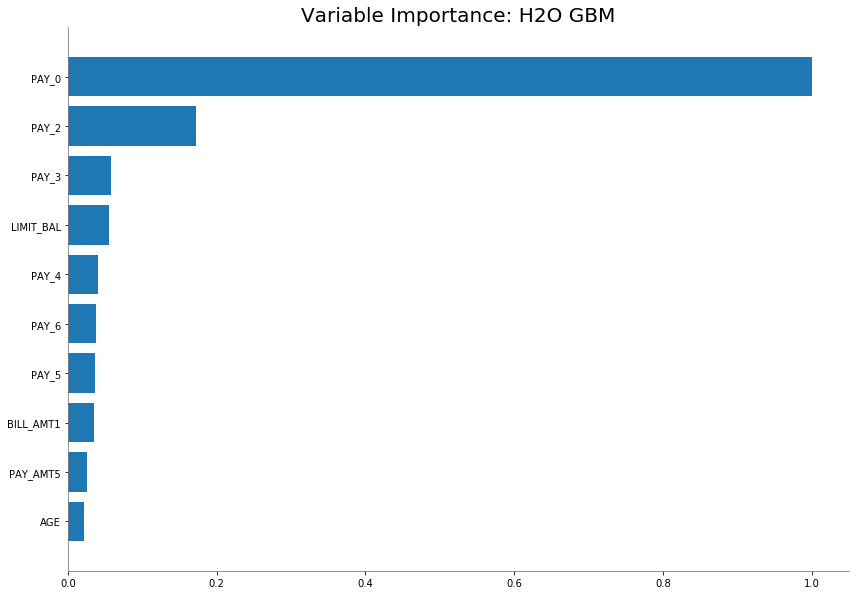

In [10]:
model.varimp_plot()

In [11]:
# cbind predictions to training frame
# give them a nice name
yhat = 'p_DEFAULT_NEXT_MONTH'
preds1 = test['ID'].cbind(model.predict(test).drop(['predict', 'p0']))
preds1.columns = ['ID', yhat]
test_yhat = test.cbind(preds1[yhat]).as_data_frame()

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [12]:
def get_prroc(frame, y, yhat, pos=1, neg=0, res=0.01):
    
    """ Calculates precision, recall, and f1 for a pandas dataframe of y and yhat values.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        pos: Primary target value, default 1.
        neg: Secondary target value, default 0.
        res: Resolution by which to loop through cutoffs, default 0.01.
    
    Returns:
        Pandas dataframe of precision, recall, and f1 values. 
    """
    
    frame_ = frame.copy(deep=True) # don't destroy original data
    dname = 'd_' + str(y) # column for predicted decisions
    eps = 1e-100 # for safe numerical operations
    
    # init p-r roc frame
    prroc_frame = pd.DataFrame(columns=['cutoff', 'recall', 'precision', 'f1'])
    
    # loop through cutoffs to create p-r roc frame
    for cutoff in np.arange(0, 1 + res, res):

        # binarize decision to create confusion matrix values
        frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
        
        # calculate confusion matrix values
        tp = frame_[(frame_[dname] == pos) & (frame_[y] == pos)].shape[0]
        fp = frame_[(frame_[dname] == pos) & (frame_[y] == neg)].shape[0]
        tn = frame_[(frame_[dname] == neg) & (frame_[y] == neg)].shape[0]
        fn = frame_[(frame_[dname] == neg) & (frame_[y] == pos)].shape[0]
        
        # calculate precision, recall, and f1
        recall = (tp + eps)/((tp + fn) + eps)
        precision = (tp + eps)/((tp + fp) + eps)
        f1 = 2/((1/(recall + eps)) + (1/(precision + eps)))
        
        # add new values to frame
        prroc_frame = prroc_frame.append({'cutoff': cutoff,
                                          'recall': recall,
                                          'precision': precision,
                                          'f1': f1}, 
                                          ignore_index=True)
    
    # housekeeping
    del frame_
    
    return prroc_frame
        
prroc_frame = get_prroc(test_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH')

In [13]:
best_cut = prroc_frame.loc[prroc_frame['f1'].idxmax(), 'cutoff'] # Find cutoff w/ max F1

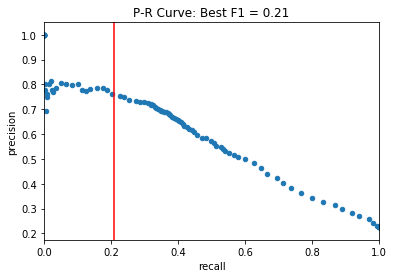

In [14]:
# Plot P-R ROC w/ best cutoff
title_ = 'P-R Curve: Best F1 = ' + str(best_cut)
ax = prroc_frame.plot(x='recall', y='precision', kind='scatter', title=title_, xlim=[0,1])
_ = ax.axvline(best_cut, color='r')

In [15]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5):

    """ Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced 
        by a variable and level.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        by: By variable to slice frame before creating confusion matrix, default None.
        level: Value of by variable to slice frame before creating confusion matrix, default None.
        cutoff: Cutoff threshold for confusion matrix, default 0.5. 

    Returns:
        Confusion matrix as pandas dataframe. 
    """
    
    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list], 
                            index=['predicted: ' + str(i) for i in level_list])
    
    # don't destroy original data
    frame_ = frame.copy(deep=True)
    
    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
    
    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]
    
    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[i, j] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
    
    # output results
    if by is None:
        print('Confusion matrix:')
    else:
        print('Confusion matrix by ' + by + '=' + level)
    
    return cm_frame
    
    
get_confusion_matrix(test_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH', cutoff=best_cut)

Confusion matrix:


,actual: 1,actual: 0
predicted: 1,1253,750
predicted: 0,1334,5603


In [16]:
ed_levels = list(test_yhat['EDUCATION'].unique())
ed_levels

['university', 'high school', 'graduate school', 'other']

In [17]:
other_cm = get_confusion_matrix(test_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH', by='EDUCATION', level='other', cutoff=best_cut)
other_cm

Confusion matrix by EDUCATION=other


,actual: 1,actual: 0
predicted: 1,2,9
predicted: 0,6,116


In [18]:
hs_cm = get_confusion_matrix(test_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH', by='EDUCATION', level='high school', cutoff=best_cut)
hs_cm

Confusion matrix by EDUCATION=high school


,actual: 1,actual: 0
predicted: 1,253,102
predicted: 0,280,831


In [19]:
uni_cm = get_confusion_matrix(test_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH', by='EDUCATION', level='university', cutoff=best_cut)
uni_cm

Confusion matrix by EDUCATION=university


,actual: 1,actual: 0
predicted: 1,633,388
predicted: 0,655,2515


In [20]:
gs_cm = get_confusion_matrix(test_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH', by='EDUCATION', level='graduate school', cutoff=best_cut)
gs_cm

Confusion matrix by EDUCATION=graduate school


,actual: 1,actual: 0
predicted: 1,365,251
predicted: 0,393,2141


In [21]:
# represent metrics as dictionary for use later
metric_dict = {

#### overall performance
'Prevalence': '(tp + fn) / (tp + tn +fp + fn)', # how much default actually happens for this group
'Accuracy':   '(tp + tn) / (tp + tn +fp + fn)', # how often the model predicts default correctly for this group

#### predicting default will happen
# (correctly)
'True Positive Rate': 'tp / (tp + fn)',  # out of the people in the group *that did* default, how many the model predicted *correctly* would default              
'Precision':          'tp / (tp + fp)',  # out of the people in the group the model *predicted* would default, how many the model predicted *correctly* would default

#### predicting default won't happen
# (correctly)
'Specificity':              'tn / (fp + tn)', # out of the people in the group *that did not* default, how many the model predicted *correctly* would not default
'Negative Predicted Value': 'tn / (tn + fn)', # out of the people in the group the model *predicted* would not default, how many the model predicted *correctly* would not default  

#### analyzing errors - type I
# false accusations 
'False Positive Rate':  'fp / (fp + tn)', # out of the people in the group *that did not* default, how many the model predicted *incorrectly* would default
'False Discovery Rate': 'fp / (tp + fp)', # out of the people in the group the model *predicted* would default, how many the model predicted *incorrectly* would default

#### analyzing errors - type II
# costly ommisions
'False Negative Rate': 'fn / (tp + fn)', # out of the people in the group *that did* default, how many the model predicted *incorrectly* would not default
'False Omissions Rate':'fn / (tn + fn)'  # out of the people in the group the model *predicted* would not default, how many the model predicted *incorrectly* would not default
}    

In [22]:
# small utility function
# translates abbreviated metric expressions into executable statements
def cm_exp_parser(expression):
    
    # tp | fp       # cm_list[i].iat[0, 0] | cm_list[i].iat[0, 1]
    # -------  ==>  # --------------------------------------------
    # fn | tn       # cm_list[i].iat[1, 0] | cm_list[i].iat[1, 1]

    expression = expression.replace('tp', 'cm_list[i].iat[0, 0]')\
                           .replace('fp', 'cm_list[i].iat[0, 1]')\
                           .replace('fn', 'cm_list[i].iat[1, 0]')\
                           .replace('tn', 'cm_list[i].iat[1, 1]')

    return expression


In [23]:
# initialize list of confusion matrices and corresponding rows of dataframe
cm_list = [other_cm, hs_cm, uni_cm, gs_cm] 
metrics_frame = pd.DataFrame(index=ed_levels) # frame for metrics

# nested loop through:
# - confusion matrices
# - races
# - metrics 
for cm in cm_list:
    for i, level in enumerate(ed_levels):
            for metric in metric_dict.keys():
              
                # parse metric expressions into executable pandas statements
                expression = cm_exp_parser(metric_dict[metric])
                
                # dynamically evaluate metrics to avoid code duplication
                metrics_frame.loc[level, metric] = eval(expression)  

# display results                
metrics_frame

,Prevalence,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
university,0.060150,0.887218,0.250000,0.181818,0.928000,0.950820,0.072000,0.818182,0.750000,0.049180
high school,0.363574,0.739427,0.474672,0.712676,0.890675,0.747975,0.109325,0.287324,0.525328,0.252025
graduate school,0.307325,0.751133,0.491460,0.619980,0.866345,0.793375,0.133655,0.380020,0.508540,0.206625
other,0.240635,0.795556,0.481530,0.592532,0.895067,0.844909,0.104933,0.407468,0.518470,0.155091


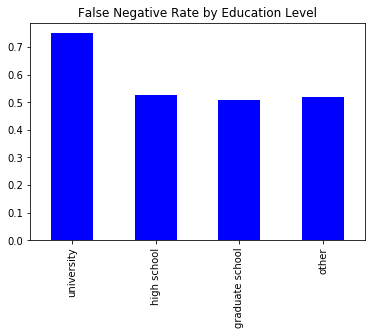

In [24]:
_ = metrics_frame['False Negative Rate'].plot(kind='bar', color='b', title='False Negative Rate by Education Level')

In [25]:
parity_threshold_low = 0.8
parity_threshold_hi = 1.25

In [26]:
ref_level = 'graduate school'

# init frame to store disparity measures
disp_frame = pd.DataFrame(index=ed_levels)

# compare all metrics to reference level
disp_frame = metrics_frame/metrics_frame.loc[ref_level, :]

# change column names
disp_frame.columns=[col + ' Disparity' for col in metrics_frame.columns]

# small utility function to format pandas table output
def disparate_red(val):
    
    color = 'blue' if (parity_threshold_low < val < parity_threshold_hi) else 'red'
    return 'color: %s' % color 

# display results
disp_frame.style.applymap(disparate_red)

,Prevalence Disparity,Accuracy Disparity,True Positive Rate Disparity,Precision Disparity,Specificity Disparity,Negative Predicted Value Disparity,False Positive Rate Disparity,False Discovery Rate Disparity,False Negative Rate Disparity,False Omissions Rate Disparity
university,0.195722,1.18117,0.508689,0.293264,1.07117,1.19845,0.538701,2.153,1.47481,0.238018
high school,1.18303,0.984415,0.965841,1.14951,1.02808,0.942775,0.817963,0.756077,1.03301,1.21973
graduate school,1,1,1,1,1,1,1,1,1,1
other,0.782998,1.05914,0.979796,0.955728,1.03315,1.06496,0.785105,1.07223,1.01953,0.750592


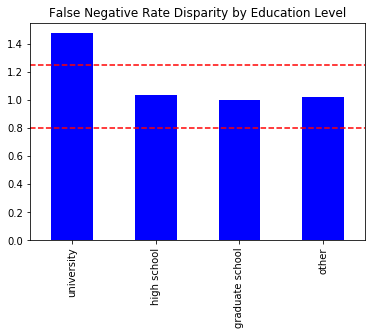

In [27]:
ax = disp_frame['False Negative Rate Disparity'].plot(kind='bar', color='b', title='False Negative Rate Disparity by Education Level')
_ = ax.axhline(parity_threshold_low, color='r', linestyle='--')
_ = ax.axhline(parity_threshold_hi, color='r', linestyle='--')

In [28]:
# parity checks
# low_threshold (0.8) < *_metric/white_metric < (high_threshold) 1.25 => parity, else disparity 

# init frame for parity
par_frame = pd.DataFrame(index=ed_levels, 
                         columns=[col + ' Parity' for col in metrics_frame.columns])
# nested loop through: 
# - races
# - disparity metrics
for i, _ in enumerate(ed_levels):
    for j, _ in enumerate(par_frame.columns):
        par_frame.iat[i, j] = (parity_threshold_low < disp_frame.iat[i, j] < parity_threshold_hi)

# add overall parity checks
# Type I Parity: Fairness in both FDR Parity and FPR Parity
# Type II Parity: Fairness in both FOR Parity and FNR Parity
# Equalized Odds: Fairness in both FPR Parity and TPR Parity
# Supervised Fairness: Fairness in both Type I and Type II Parity
# Overall Fairness: Fairness across all parities for all attributes
par_frame['Type I Parity'] = (par_frame['False Discovery Rate Parity']) & (par_frame['False Positive Rate Parity'])
par_frame['Type II Parity'] = (par_frame['False Omissions Rate Parity']) & (par_frame['False Negative Rate Parity'])
par_frame['Equalized Odds'] = (par_frame['False Positive Rate Parity']) & (par_frame['True Positive Rate Parity'])
par_frame['Supervised Fairness'] = (par_frame['Type I Parity']) & (par_frame['Type II Parity'])
par_frame['Overall Fairness'] = par_frame.all(axis='columns')
    
# small utility function to format pandas table output    
def color_false_red(val):

    color = 'red' if not val else 'blue'
    return 'color: %s' % color 
    
par_frame.style.applymap(color_false_red)

,Prevalence Parity,Accuracy Parity,True Positive Rate Parity,Precision Parity,Specificity Parity,Negative Predicted Value Parity,False Positive Rate Parity,False Discovery Rate Parity,False Negative Rate Parity,False Omissions Rate Parity,Type I Parity,Type II Parity,Equalized Odds,Supervised Fairness,Overall Fairness
university,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False
high school,True,True,True,True,True,True,True,False,True,True,False,True,True,False,False
graduate school,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
other,False,True,True,True,True,True,False,True,True,False,False,False,False,False,False
